In [107]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread

import seaborn as sns

from sklearn import decomposition

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppi_vgg16
from tensorflow.keras.models import Sequential

import os

import warnings

In [108]:
warnings.filterwarnings("ignore")

# CONSTANTS

In [109]:
RAW_DATA_FILE_PATH = 'data/raw/'                # path to raw data folder
CLEANED_DATA_FILE_PATH = 'data/cleaned/'        # path to cleaned data folder
IMAGES_DIR = "data/raw/"                        # path to images

# FUNCTIONS

In [110]:
def preprocess_images(ppi,my_new_model):
    feature_list = []

    image_num = 0

    for path, subdirs, files in os.walk(RAW_DATA_FILE_PATH):
        for name in files:
            image_num = image_num + 1
            if image_num%10 == 0 : print(image_num,name)
            file = os.path.join(path, name)
            im = imread(file)
            img = ppi(np.expand_dims(im.copy(), axis=0))
            feature = my_new_model.predict(img)
            feature_np = np.array(feature)
            feature_list.append(feature_np.flatten())
    array = np.array(feature_list)
    return array

In [111]:
def run_model(model,ppi):
    my_new_model = Sequential()
    my_new_model.add(model)
    # Say not to train first layer (ResNet) model. It is already trained
    my_new_model.layers[0].trainable = False
    array = preprocess_images(ppi,my_new_model)
    return array

# READ IMAGES, CREATE DATAFRAME

In [112]:
# read images, create df of filenames, and class (which type)

fv = pd.DataFrame(columns=['filename','fv_class'])

for path, subdirs, files in os.walk(RAW_DATA_FILE_PATH):
    for name in files:
        subfolder_name = path.replace(RAW_DATA_FILE_PATH,'')
        fv.loc[len(fv)] = [name,subfolder_name]
        
fv.head()

,filename,fv_class
0,0_100.jpg,banana
1,128_100.jpg,banana
2,180_100.jpg,banana
3,270_100.jpg,banana
4,35_100.jpg,banana


# VECTORIZATION BY VGG16

In [113]:
model = VGG16(include_top=False, pooling='avg', weights='imagenet')
array = run_model(model,ppi_vgg16)

10 235_100.jpg
20 100_100.jpg
30 158_100.jpg


# CREATE VECTOR DATAFRAME FROM VGG16 RESULTS

In [114]:
# create df from model vector
df_vec = pd.DataFrame(array)

# add image filename and category
df_vec['filename'] = fv.filename
df_vec['fv_class'] = fv.fv_class

df_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,filename,fv_class
0,0.000000,1.671766,0.703813,0.000000,0.853446,0.000000,0.000000,1.083064,0.0,2.560714,...,0.000000,0.0,2.070888,0.0,0.0,0.000000,0.408518,0.000000,0_100.jpg,banana
1,0.000000,6.656352,0.000000,1.003132,2.579631,0.000000,9.956829,0.000000,0.0,0.000000,...,0.856359,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,128_100.jpg,banana
2,1.884784,2.675988,0.719963,0.000000,4.340486,3.075186,6.648093,0.000000,0.0,0.343381,...,0.000000,0.0,3.260953,0.0,0.0,1.777546,0.540553,0.000000,180_100.jpg,banana
3,0.000000,4.177713,0.000000,0.000000,2.412080,0.000000,0.000000,0.000000,0.0,16.823223,...,0.000000,0.0,6.579794,0.0,0.0,0.014079,0.818676,0.000000,270_100.jpg,banana
4,0.000000,1.119263,0.000000,0.000000,3.402102,0.996732,1.910960,0.000000,0.0,0.000000,...,0.000000,0.0,4.131537,0.0,0.0,0.000000,0.000000,0.046131,35_100.jpg,banana


# RUN PCA FOR REDUCTION TO 2 COMPONENTS

In [115]:
# define pca
pca = decomposition.PCA(n_components=2)

# run pca
array_pca_out = pca.fit_transform(df_vec.drop(columns=['filename','fv_class']))

# pca results to dataframe
df_pca = pd.DataFrame(array_pca_out)

# add filename and category
df_pca['filename'] = df_vec['filename']
df_pca['fv_class'] = df_vec['fv_class']

df_pca.head()

,0,1,filename,fv_class
0,-42.425919,119.633118,0_100.jpg,banana
1,-14.384988,173.165054,128_100.jpg,banana
2,-41.490170,73.415344,180_100.jpg,banana
3,-19.745312,165.935638,270_100.jpg,banana
4,-35.896481,65.490448,35_100.jpg,banana


# MATPLOTLIB SCATTER PLOT

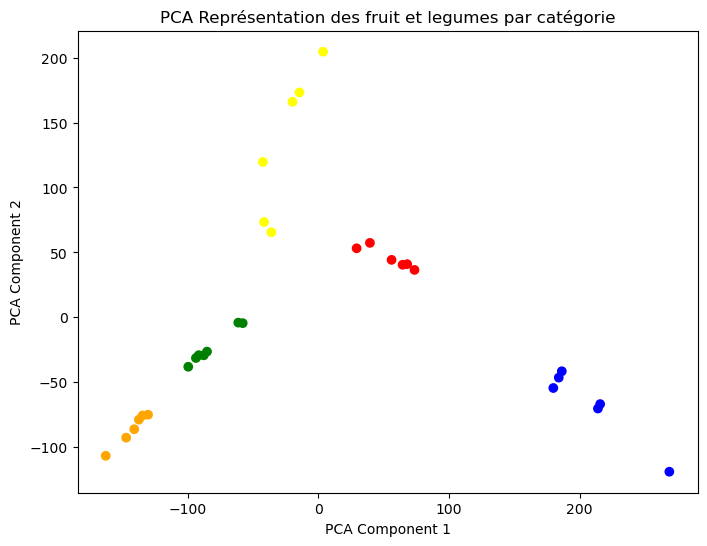

In [116]:
# start plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# colormap for scatterplot
colours = {'pear':'green',
    'banana':'yellow',
    'cauliflower':'blue',
    'ginger':'red',
    'grannysmith':'orange'}

scatter = ax.scatter(df_pca[0],df_pca[1],c=df_pca['fv_class'].map(colours))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Représentation des fruit et legumes par catégorie')
plt.show()

# SEABORN SCATTERPLOT

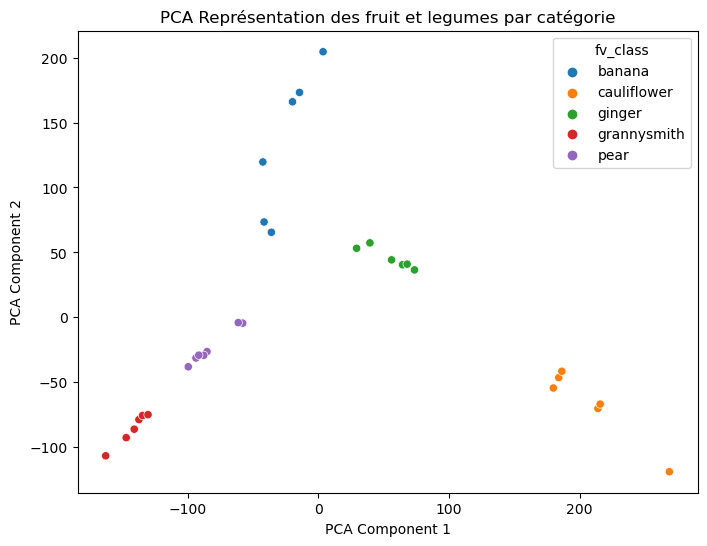

In [117]:
# scatter with seaborn

# start plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=df_pca, x=0, y=1, hue='fv_class')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Représentation des fruit et legumes par catégorie')
plt.show()